In [77]:
!mkdir ../dataset 
!wget -O ../dataset/KDDTrain+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt
!wget -O ../dataset/KDDTest+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest%2B.txt
!wget -O ../dataset/KDDTrain+_20Percent.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B_20Percent.txt
!wget -O ../dataset/KDDTest-21.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest-21.txt

mkdir: cannot create directory ‘../dataset’: File exists
--2022-03-06 07:48:03--  https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19109424 (18M) [text/plain]
Saving to: ‘../dataset/KDDTrain+.txt’

../dataset/KDDTrain 100%[===================>]  18.22M  --.-KB/s    in 0.06s   

2022-03-06 07:48:03 (293 MB/s) - ‘../dataset/KDDTrain+.txt’ saved [19109424/19109424]

--2022-03-06 07:48:03--  https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest%2B.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|1

In [78]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold as KFold
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [79]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [80]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Loading Dataset
# Dataset link: https://data.mendeley.com/datasets/xvyv59vwvz/1
# Dataset is present in the current directory containing the code file.
df=pd.read_csv('../dataset/KDDTrain+.txt', header=None)
df2=pd.read_csv('../dataset/KDDTest+.txt', header=None)

## Preprocessing

In [81]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [82]:
df.columns = [str(i) for i in range(0, len(df.columns))]
df2.columns = [str(i) for i in range(0, len(df2.columns))]

In [83]:
# Replacing Null values with 0. ML classifer cannot learn on Null values
df.fillna(0, inplace=True)
df2.fillna(0, inplace=True)

In [84]:
# Peak on dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [85]:
df.shape

(125973, 43)

In [86]:
# Peak on the dataset
df.drop('42',axis=1, inplace=True)
df2.drop('42',axis=1, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [87]:
sub_classes = df.iloc[:,41].value_counts()

In [88]:
print(sub_classes)

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: 41, dtype: int64


In [89]:
r2l = ['ftp_write','guess_passwd', 'imap', 'multihop', 'phf', 'spy','warezclient','warezmaster','xlock', 'xsnoop','named',
       'sendmail','snmpgetattack', 'snmpguess','httptunnel']
u2r = ['buffer_overflow', 'loadmodule','perl','ps','rootkit','sqlattack','xterm']
dos = ['back', 'land', 'neptune', 'smurf', 'teardrop','pod','mailbomb', 'processtable','udpstorm', 'worm','apache2']
probe = ['ipsweep', 'nmap', 'portsweep', 'satan','saint','mscan']

In [90]:
df['41'] = df['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

df2['41'] = df2['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )


### Training set value counts

In [91]:
print(df['41'].value_counts())

normal       67343
malicious    58630
Name: 41, dtype: int64


### Testing set value counts

In [92]:
print(df2['41'].value_counts())

malicious    12833
normal        9711
Name: 41, dtype: int64


In [93]:
# Encodings Labels so that they are compatible with machine leanring classifiers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in df:
    if df[i].dtype=='object':
        df[i] = le.fit_transform(df[i])
    else:
        continue
for i in df2:
    if df2[i].dtype=='object':
        df2[i] = le.fit_transform(df2[i])
    else:
        continue
        
X_train = df.drop(['41'],axis=1)
y_train = df['41']

X_test = df2.drop(['41'],axis=1)
y_test = df2['41']

In [94]:
# Scaling data. Default scaling is to scale the data to unit variance (or equivalent
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_train = torch.tensor(X_train, dtype=torch.float)

X_test = mms.fit_transform(X_test)
X_test = torch.tensor(X_test, dtype=torch.float)

## **CNN Wing 2**



In [95]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pt_x_train = X_train.to(device)
pt_y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = X_test.to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)
pt_train = TensorDataset(pt_x_train, pt_y_train)
pt_train = DataLoader(pt_train, batch_size=64)

In [96]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.cnn = nn.Sequential(
          nn.Conv1d(1,3,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(3),
          nn.Conv1d(3,3,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(3),
          nn.Conv1d(3,3,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(3),
          nn.Conv1d(3,3,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(3),
          nn.Flatten(),
          nn.Linear(99, 41),
          nn.ReLU()
        )

        self.clf = nn.Sequential(
            nn.Linear(41,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.cnn(x)
        return self.clf(features)

    def transform(self, x):
        return self.cnn(x)

In [97]:
cnn = CNN2().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr = 1e-1)

In [98]:
num_epochs = 50
outputs = []
losses = []
for epoch in range(num_epochs):
    for instance, y in pt_train:
        output = cnn(instance.view(-1,1,1,41))
        loss = criterion(output, y.view(-1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')

Epoch:1, Loss:0.0355
Epoch:2, Loss:0.0079
Epoch:3, Loss:0.0068
Epoch:4, Loss:0.0060
Epoch:5, Loss:0.0056
Epoch:6, Loss:0.0086
Epoch:7, Loss:0.0063
Epoch:8, Loss:0.0049
Epoch:9, Loss:0.0042
Epoch:10, Loss:0.0035
Epoch:11, Loss:0.0041
Epoch:12, Loss:0.0036
Epoch:13, Loss:0.0038
Epoch:14, Loss:0.0033
Epoch:15, Loss:0.0031
Epoch:16, Loss:0.0027
Epoch:17, Loss:0.0026
Epoch:18, Loss:0.0026
Epoch:19, Loss:0.0035
Epoch:20, Loss:0.0030
Epoch:21, Loss:0.0036
Epoch:22, Loss:0.0028
Epoch:23, Loss:0.0035
Epoch:24, Loss:0.0028
Epoch:25, Loss:0.0027
Epoch:26, Loss:0.0042
Epoch:27, Loss:0.0035
Epoch:28, Loss:0.0031
Epoch:29, Loss:0.0027
Epoch:30, Loss:0.0030
Epoch:31, Loss:0.0026
Epoch:32, Loss:0.0026
Epoch:33, Loss:0.0042
Epoch:34, Loss:0.0031
Epoch:35, Loss:0.0032
Epoch:36, Loss:0.0034
Epoch:37, Loss:0.0033
Epoch:38, Loss:0.0027
Epoch:39, Loss:0.0038
Epoch:40, Loss:0.0020
Epoch:41, Loss:0.0034
Epoch:42, Loss:0.0016
Epoch:43, Loss:0.0023
Epoch:44, Loss:0.0026
Epoch:45, Loss:0.0016
Epoch:46, Loss:0.00

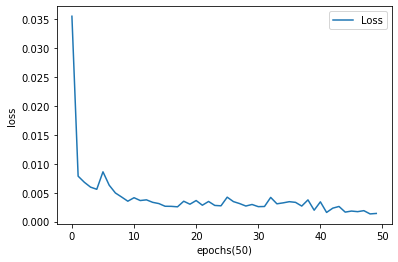

In [99]:
plt.plot(losses)
plt.xlabel(f"epochs({num_epochs})")
plt.ylabel(f"loss")
_ = plt.legend(['Loss'])

In [100]:
cnn.eval()
with torch.no_grad():
  train_X = cnn.transform(X_train.view(-1,1,1,41).to(device))
  lr_probs = cnn(X_test.view(-1,1,1,41)).cpu().squeeze()

In [101]:
'''confidence_coef = 0.25
threshold = 0.5
for i,confidence in enumerate(lr_probs):
  if confidence < threshold + confidence_coef:
    lr_probs[i] = 0'''

'confidence_coef = 0.25\nthreshold = 0.5\nfor i,confidence in enumerate(lr_probs):\n  if confidence < threshold + confidence_coef:\n    lr_probs[i] = 0'

In [102]:
preds = torch.round(lr_probs)

In [103]:
cm = confusion_matrix(y_test, preds)
tn=cm[1][1] #tn
fn=cm[0][1] #fn
fp=cm[1][0] #fp
tp=cm[0][0] #tp
acc= (tp+tn)/(tp+tn+fn+fp)
epsilon = 1e-7 # is used so that to avoid divide by zero error
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
print("Test accuracy is:"+str(format(acc,'.4f')))
print("Precision: "+str(format(precision,'.4f'))+" Recall: "+str(format(recall,'.4f')))

Test accuracy is:0.7926
Precision: 0.9681 Recall: 0.6574


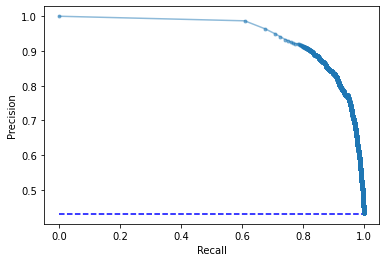

F1:	 80.141%
AUC:	 94.667%
Accuracy:79.263%


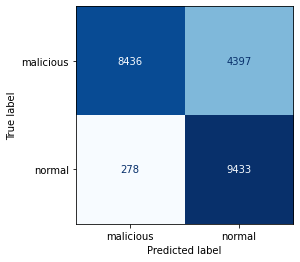

In [104]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, preds), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
acc = accuracy_score(y_test, preds)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', c = "blue")
plt.plot(lr_recall, lr_precision, marker='.', alpha=0.5)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the plot
plt.show()
_ = plt.rc('legend', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)
disp.plot(cmap="Blues", colorbar = False)
print(f"F1:\t {lr_f1*100:.3f}%")
print(f"AUC:\t {lr_auc*100:.3f}%")
print(f"Accuracy:{acc*100:.3f}%")

In [105]:
torch.save(cnn.state_dict(), 'cnn2.pt')